In [164]:
import binascii
import time
import os
import shutil
import numpy
from fobos import openadc, projmgr, pynqctrl, nexys3dut
from fobos.analyzer import ttestOnline
from pynq import Xlnk
import numpy as np
from pynq import Overlay
import sys
WORKSPACE       = "/home/xilinx/fobosworkspace"
PROJECT_NAME    = "aes_test"
DIN_FILE_NAME   = "dinFile.txt"
CIPHER_FILE     = "ciphertext.txt"
TRACE_FILE      = "powerTraces.npy"
#DUT_BIT_FILE    = "half_duplex_dut.bit"
DUT_BIT_FILE    = "FOBOS_DUT_2.bit"
OUT_LEN         = 4 #11# in 32-bit words
TRACE_NUM       = 10
SAMPLING_FREQ   = 100
DUT_CLK         = 1
SAMPLE_NUM      = 100
ADC_GAIN        = 20
TV_SIZE         = 48 #108
OUTPUT_SIZE     = 16 #44


In [166]:
overlay = Overlay("ctrl_top_wrapper_rising.bit")
fobosAcq = openadc.OpenADCScope(overlay)
fobosAcq.setAdcClockFreq(SAMPLING_FREQ)
fobosAcq.setGain(ADC_GAIN)
xlnk = Xlnk()
#Wee need to reserver number of block + 2 locations
outputBuffer = xlnk.cma_array(shape=(int(SAMPLE_NUM / 4 + 2),), dtype=np.uint64)
##########################
###configure worksapce
pm = projmgr.ProjectManager()
pm.setWorkSpaceDir(WORKSPACE)
pm.setProjName(PROJECT_NAME)
projDir = pm.getProjDir()
##########################
#configure controller
ctrl = pynqctrl.PYNQCtrl(overlay, inputSize = TV_SIZE, outputSize = OUTPUT_SIZE)
ctrl.setDUTClk(DUT_CLK)
ctrl.setOutLen(OUT_LEN)
ctrl.setTriggerMode(pynqctrl.PYNQCtrl.TRG_FULL)
ctrl.setDUTInterface(pynqctrl.PYNQCtrl.INTERFACE_8BIT)

##########################
#configure DUT
dut = nexys3dut.Nexys3DUT()
bitFile = os.path.join(projDir, DUT_BIT_FILE)
dut.setBitFile(bitFile)
dut.program()

/usr/local/lib/python3.6/dist-packages/pynq/lib/dma.py:200: UserWarning: Failed to find parameter c_sg_length_width; users should really use *.hwh files for overlays.
  warnings.warn(message, UserWarning)


clkout 102
2 1 0
clkout 50
divInt
50
divFrac
0.0
divInt
50
divFrac
0
Set clk frequency to 1.0
Programming device using the following commands:
sudo -u xilinx djtgcfg init -d Nexys3
sudo -u xilinx djtgcfg prog -d Nexys3 -i 0 -f /home/xilinx/fobosworkspace/aes_test/FOBOS_DUT_2.bit
b'Programming device. Do not touch your board. This may take a few minutes...\nProgramming succeeded.\n'


In [168]:
ctrl.forceReset()
time.sleep(1)
ctrl.releaseReset()
##########################
#setup i/o files
tvFileName = os.path.join(projDir, DIN_FILE_NAME)
tvFile = open(tvFileName, "r")
captureDir = pm.getCaptureDir()
cipherFileName = os.path.join(captureDir, CIPHER_FILE)
cipherFile = open(cipherFileName, "w")
traceFileName = os.path.join(captureDir, TRACE_FILE)
traceFile = open(traceFileName, "a+b")
#print("Copying test-vector file to attempt directory ...")
#shutil.copy(tvFileName, captureDir)
#########################
print("Loading test-vector file ...")
testVectors = tvFile.readlines()
print("Done loading.")
tic = time.time()
#traces = np.empty((TRACE_NUM, SAMPLE_NUM))
for traceNum in range(TRACE_NUM):
    fobosAcq.arm(outputBuffer,int(SAMPLE_NUM/4))
    result = ctrl.processData(testVectors[traceNum])
    fobosAcq.waitForTrace()
    #change data typy before saving
    trace = outputBuffer.view('uint16')
    #trace= trace[:SAMPLE_NUM]
    #traces[traceNum, :] = trace
    cipherFile.write(result + '\n')
    #c = fvrFile.read(1)
    #if c == "0":
        #numpy.save(traceFile0, trace)
     #   ttestCalc.addTrace(trace, 0)
    #else:
     #   ttestCalc.addTrace(trace, 1)
        #numpy.save(traceFile1, trace)
    numpy.save(traceFile, trace)
    if traceNum % 1000 == 0:
        sys.stdout.write("Progress: {}%\r".format(traceNum/TRACE_NUM *100 ))
        sys.stdout.flush()
        #ttestPlotFile = os.path.join(captureDir, "ttest{}".format(traceNum))
        #ttestCalc.plot(ttestPlotFile)
    #time.sleep(4)
#numpy.save(traceFile,traces)
#traces = None #Free memory
outputBuffer.freebuffer()
cipherFile.close()
tvFile.close()
traceFile.close()

toc = time.time()
print("Time elapsed = {} seconds.".format(toc - tic))

Successfully created new capture directory at /home/xilinx/fobosworkspace/aes_test/capture/attempt-159
Loading test-vector file ...
Done loading.
Time elapsed = 0.06527066230773926 seconds.


/home/xilinx/fobosworkspace/aes_test/capture/attempt-159/powerTraces.npy
(108,)


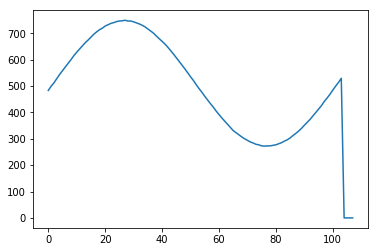

In [169]:
import matplotlib.pyplot as plt
%matplotlib inline
f = open(traceFileName, 'rb')
print(traceFileName)
dataToPlot = numpy.load(f)
plt.plot(dataToPlot[0:4000])
print(dataToPlot.shape)
#print(dataToPlot)
plt.savefig(os.path.join(captureDir,"aes.png"))
plt.show()
#plt.clf()